In [1]:
from cytorcnn import CytoRCNN, utilities
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import math
from shapely.geometry import Polygon
from shapely.ops import unary_union

In [2]:
!nvidia-smi

Thu Feb 20 12:49:09 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:07:00.0 Off |                    0 |
| N/A   34C    P0              95W / 400W |   2468MiB / 40960MiB |     30%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [10]:
weights_path = "/u/home/s/syeh/project-hugowill/cytorcnn/model.pth"
folder_path = "/u/home/s/syeh/project-hugowill/images/VMI_256-64"
dir_list = os.listdir(folder_path)
unsorted_new_dir_list = []
for filename in os.listdir(folder_path):
    x, y = filename[:-4].split("_")
    x = int(x)
    y = int(y)
    new_filename = f"{x + y}_{x}_{y}.png"
    unsorted_new_dir_list.append(new_filename)
new_dir_list = sorted(unsorted_new_dir_list, key=lambda x: int(x.split('_')[0]))

In [7]:
print(new_dir_list)

['0_0_0.png', '1_0_1.png', '1_1_0.png', '2_0_2.png', '2_1_1.png', '2_2_0.png', '3_1_2.png', '3_0_3.png', '3_2_1.png', '3_3_0.png', '4_4_0.png', '4_1_3.png', '4_0_4.png', '4_3_1.png', '4_2_2.png', '5_4_1.png', '5_3_2.png', '5_2_3.png', '5_1_4.png', '5_0_5.png', '5_5_0.png', '6_2_4.png', '6_5_1.png', '6_6_0.png', '6_4_2.png', '6_0_6.png', '6_1_5.png', '6_3_3.png', '7_0_7.png', '7_2_5.png', '7_5_2.png', '7_7_0.png', '7_6_1.png', '7_4_3.png', '7_3_4.png', '7_1_6.png', '8_8_0.png', '8_1_7.png', '8_4_4.png', '8_0_8.png', '8_3_5.png', '8_7_1.png', '8_5_3.png', '8_2_6.png', '8_6_2.png', '9_7_2.png', '9_2_7.png', '9_0_9.png', '9_8_1.png', '9_6_3.png', '9_3_6.png', '9_9_0.png', '9_5_4.png', '9_1_8.png', '9_4_5.png', '10_7_3.png', '10_8_2.png', '10_9_1.png', '10_0_10.png', '10_6_4.png', '10_1_9.png', '10_2_8.png', '10_4_6.png', '10_3_7.png', '10_5_5.png', '10_10_0.png', '11_10_1.png', '11_8_3.png', '11_4_7.png', '11_7_4.png', '11_9_2.png', '11_1_10.png', '11_6_5.png', '11_11_0.png', '11_3_8.png',

In [4]:
def polygon_combine(coord1, coord2, threshold):
    polygon1 = Polygon(coord1)
    polygon2 = Polygon(coord2)
    if not polygon1.intersects(polygon2):
        return False

    intersect = polygon1.intersection(polygon2).area
    union = polygon1.area + polygon2.area - intersect
    IOU = intersect/union
    merged = polygon1.union(polygon2)
    if IOU > threshold:
        if merged.geom_type == "Polygon":
            coords = np.array(merged.exterior.coords)
        return coords, IOU, merged.geom_type
    return False

In [ ]:
import time

global_polygons = []
cytorcnn = CytoRCNN(weights_path)

prev_index = curr_index = 0
curr_polygons = prev_polygons = []
for file in new_dir_list:
    ti = time.time()
    curr_index, column, row = file.split('_')
    column = int(column)
    row = int(row[:-4])
    
    if prev_index != curr_index:
        prev_polygons = curr_polygons
        for polygon in curr_polygons:
            global_polygons.append(polygon)
        curr_polygons = []
    
    image_path = os.path.join(folder_path, f"{column}_{row}.png")
    cytorcnn.predict(image_path)
    
    with open('prediction.json', 'r') as file_predictions:
        data = json.load(file_predictions)
    annotations = data.get('annotations', [])
    
    for i in range(len(annotations)):
        segmentation = annotations[i].get('segmentation', None)
        category_id = annotations[i].get('category_id', None)
        num_points = len(segmentation[0])/2

        # (x, y)
        points = np.array(segmentation[0]).reshape(-1, 2).astype(int)
        x_max, y_max = np.max(points, axis=0)
        x_min, y_min = np.min(points, axis=0)
        
        points[:, 0] += column * 256 - 64 * column
        points[:, 1] += row * 256 - 64 * row
        
        if x_max < 255 and y_max < 255 and x_min > 0 and y_min > 0:
            best_points = points
            threshold = 0.1
            indexes = []
            for j in range(len(prev_polygons)):
                if prev_polygons[j]["category_id"] == category_id:
                    output = polygon_combine(best_points, prev_polygons[j]["points"], threshold)
                    if not output:
                        continue
                    else:
                        new_points, IOU, poly_type = output
                        best_points = new_points
                        indexes.append(j)
            ncurr_polygons = [item for i, item in enumerate(curr_polygons) if i not in indexes]
            curr_polygons = ncurr_polygons
            polygon_data = {"points": best_points, "category_id": category_id}
            curr_polygons.append(polygon_data)
    print(file, f"{time.time() - ti} s")
    prev_index = curr_index

0_0_0.png 0.03880596160888672 s
1_0_1.png 0.032195329666137695 s
1_1_0.png 0.032302141189575195 s
2_0_2.png 0.0317997932434082 s
2_1_1.png 0.030903339385986328 s
2_2_0.png 0.032514095306396484 s
3_1_2.png 0.08100152015686035 s
3_0_3.png 0.06150078773498535 s
3_2_1.png 0.04670906066894531 s
3_3_0.png 0.03390812873840332 s
4_4_0.png 0.03402423858642578 s
4_1_3.png 0.03445148468017578 s
4_0_4.png 0.03560805320739746 s
4_3_1.png 0.030838966369628906 s
4_2_2.png 0.03285098075866699 s
5_4_1.png 0.03258562088012695 s
5_3_2.png 0.03182363510131836 s
5_2_3.png 0.032488346099853516 s
5_1_4.png 0.03259134292602539 s
5_0_5.png 0.03880047798156738 s
5_5_0.png 0.03133749961853027 s
6_2_4.png 0.03220725059509277 s
6_5_1.png 0.03569197654724121 s
6_6_0.png 0.03306460380554199 s
6_4_2.png 0.031108617782592773 s
6_0_6.png 0.0316014289855957 s
6_1_5.png 0.03284621238708496 s
6_3_3.png 0.03175616264343262 s
7_0_7.png 0.03278970718383789 s
7_2_5.png 0.03151750564575195 s
7_5_2.png 0.03146505355834961 s
7_7

In [7]:
print(len(global_polygons), len(hashed_set))

536 536


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


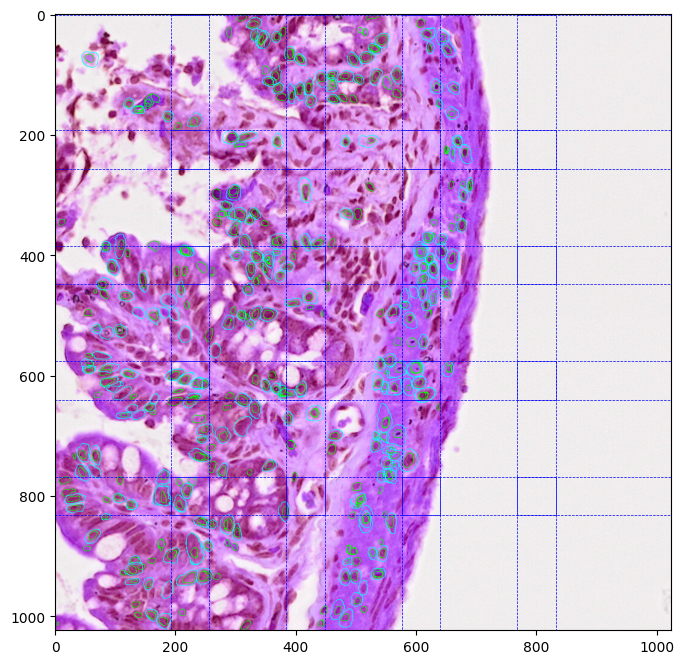

In [10]:
image_path = "/u/home/s/syeh/project-hugowill/images/center_cropped_image.png"
image = mpimg.imread(image_path)

height, width = image.shape[:2]

grid_size = 256
overlap = 64
stride = grid_size - overlap

x_starts = np.arange(0, width - grid_size + 1, stride)
y_starts = np.arange(0, height - grid_size + 1, stride)

for polygon in global_polygons:
    points = polygon["points"].reshape(-1, 1, 2).astype(int)
    if polygon["category_id"] == 0:
        cv2.polylines(image, points, isClosed=True, color=(0, 255, 0), thickness=1)
    elif polygon["category_id"] == 1:
        cv2.polylines(image, points, isClosed=True, color=(0, 255, 255), thickness=1)
        

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('on')

for x in x_starts:
    for y in y_starts:
        rect = plt.Rectangle((x, y), grid_size, grid_size, edgecolor='blue', facecolor='none', linestyle='--', linewidth=0.5)
        plt.gca().add_patch(rect)

plt.show()


[]
[12, 27, 29, 33, 41, 45, 45, 50, 64, 67, 80, 81, 81, 85, 85, 86, 90, 91, 101, 103, 103, 106, 106, 108, 111, 112, 117, 118, 122, 125, 125, 125, 128, 129, 135, 142, 147, 148, 153, 153, 153, 155, 155, 158, 160, 164, 167, 171, 176, 189, 191, 194, 230, 241, 247]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


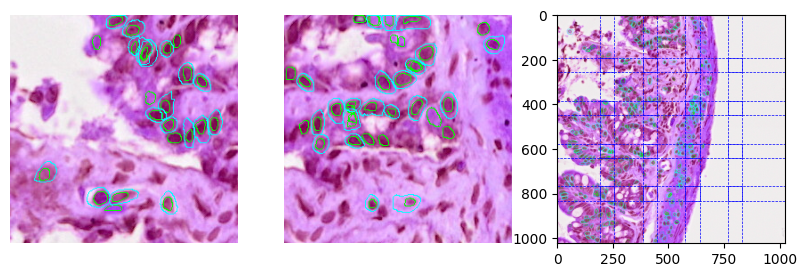

In [47]:
image_path = "/u/home/s/syeh/project-hugowill/images/VMI_256-64_test/1_0.png"
image1 = cv2.imread(image_path)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

cytorcnn.predict(image_path)

fig, axes = plt.subplots(1, 3, figsize=(10, 10))

with open('prediction.json', 'r') as file:
    data = json.load(file)
annotations = data.get('annotations', [])

all_points1 = []
for i in range(len(annotations)):
    segmentation = annotations[i].get('segmentation', None)
    category_id = annotations[i].get('category_id', None)

    num_points = len(segmentation[0])/2

    # (x, y)
    points = np.array(segmentation[0]).reshape(-1, 1, 2).astype(int)
    all_points.append(np.array(segmentation[0]).reshape(-1, 2).astype(int))

    # polygon
    if category_id == 0:
        cv2.polylines(image1, points, isClosed=True, color=(0, 255, 0), thickness=1)
    elif category_id == 1:
        cv2.polylines(image1, points, isClosed=True, color=(0, 255, 255), thickness=1)
max_x1 = sorted([arr[:, 0].astype(int).max() for arr in all_points1])
print(max_x1)
        
axes[0].imshow(image1)
axes[0].set_axis_off()
axes[1].set_axis_off()


image_path = "/u/home/s/syeh/project-hugowill/images/VMI_256-64_test/2_0.png"
image2 = cv2.imread(image_path)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

cytorcnn.predict(image_path)

with open('prediction.json', 'r') as file:
    data = json.load(file)
annotations = data.get('annotations', [])

all_points2 = []
for i in range(len(annotations)):
    segmentation = annotations[i].get('segmentation', None)
    category_id = annotations[i].get('category_id', None)

    num_points = len(segmentation[0])/2

    # (x, y)
    points = np.array(segmentation[0]).reshape(-1, 1, 2).astype(int)
    all_points2.append(np.array(segmentation[0]).reshape(-1, 2).astype(int))

    # polygon
    if category_id == 0:
        cv2.polylines(image2, points, isClosed=True, color=(0, 255, 0), thickness=1)
    elif category_id == 1:
        cv2.polylines(image2, points, isClosed=True, color=(0, 255, 255), thickness=1)
max_x2 = sorted([arr[:, 0].astype(int).max() for arr in all_points2])
print(max_x2)
        
axes[1].imshow(image2)


image_path = "/u/home/s/syeh/project-hugowill/images/center_cropped_image.png"
image = mpimg.imread(image_path)

height, width = image.shape[:2]

grid_size = 256
overlap = 64
stride = grid_size - overlap

x_starts = np.arange(0, width - grid_size + 1, stride)
y_starts = np.arange(0, height - grid_size + 1, stride)

for polygon in global_polygons:
    points = polygon["points"].reshape(-1, 1, 2).astype(int)
    if polygon["category_id"] == 0:
        cv2.polylines(image, points, isClosed=True, color=(0, 255, 0), thickness=1)
    elif polygon["category_id"] == 1:
        cv2.polylines(image, points, isClosed=True, color=(0, 255, 255), thickness=1)
for x in x_starts:
    for y in y_starts:
        rect = plt.Rectangle((x, y), grid_size, grid_size, 
                             edgecolor='blue', facecolor='none', linestyle='--', linewidth=0.5)
        plt.gca().add_patch(rect)
axes[2].imshow(image)
plt.show()

[12, 27, 29, 33, 41, 45, 45, 50, 64, 67, 80, 81, 81, 85, 85, 86, 90, 91, 101, 103, 103, 106, 106, 108, 111, 112, 117, 118, 122, 125, 125, 125, 128, 129, 135, 142, 147, 148, 153, 153, 153, 155, 155, 158, 160, 164, 167, 171, 176, 189, 191, 194, 230, 241, 247]


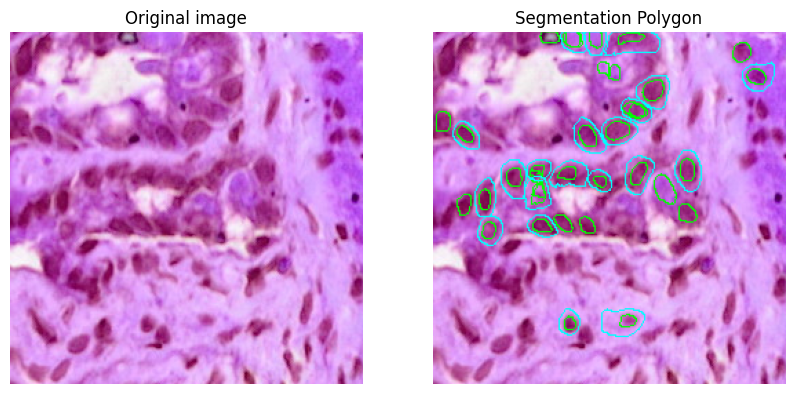